In [1]:
import pybullet as p
import pybullet_data
import time
import numpy as np
import random

from pybullet_planning import plan_joint_motion, enable_gravity, connect
from pybullet_planning import (
    get_sample_fn, get_extend_fn, get_collision_fn, get_distance_fn
)
from pybullet_planning import set_joint_positions
from pybullet_planning.motion_planners.rrt_star import rrt_star
from pybullet_planning.motion_planners.rrt_connect import rrt_connect
from pybullet_planning import get_joint_limits
import matplotlib.pyplot as plt
# Connect to GUI
client = connect(use_gui=True)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load plane and robot
plane = p.loadURDF("plane.urdf")
# robot_id = p.loadURDF("kuka_iiwa/model.urdf", useFixedBase=True)
robot_id = p.loadURDF("franka_panda/panda.urdf", useFixedBase=True)
# Enable gravity
enable_gravity()


pybullet build time: Jun  8 2025 12:43:35


In [2]:
# Example joint configurations (you can randomize or compute from IK)

joint_indices = [0,1,2,3,4,5,6]


q_start = [-1.48255645, -1.28271725,  0.51640668, -2.89752705,  2.2573049 ,
        3.54704115, -2.57267389]
q_goal = [ 0.0749903 , -0.00759137, -0.35391163, -2.28562609,  2.56747977,
        0.30896773, -1.20407494 ]



# Now arm_joint_indices should be length 7
print("Arm joints:", joint_indices)

Arm joints: [0, 1, 2, 3, 4, 5, 6]


In [ ]:
# Parameters
radius = 0.05  
obstacles = []
positions = []

# Generate 100 random positions within a defined workspace
# rerun this cell if the number of eleminated obstacles due to collision with initial or final configurations
for _ in range(100):
    x = random.uniform(-0.7, 0.7)
    y = random.uniform(-0.6, 0.6)
    z = random.uniform(0.2, 0.8)
    
    positions.append([x, y, z])

# Create visual and collision shapes once (for efficiency)
obstacle_visual = p.createVisualShape(
    shapeType=p.GEOM_SPHERE,
    radius=radius,
    rgbaColor=[1, 0, 0, 0.8]  # Red 
)

obstacle_collision = p.createCollisionShape(
    shapeType=p.GEOM_SPHERE,
    radius=radius
)

# Create each obstacle at a different position
for pos in positions:
    obstacle_id = p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=obstacle_collision,
        baseVisualShapeIndex=obstacle_visual,
        basePosition=pos
    )

    obstacles.append(obstacle_id)
set_joint_positions(robot_id, joint_indices, q_start) 
for i in range(100):
    collision_fn1 = get_collision_fn(robot_id, joint_indices, obstacles=obstacles, self_collisions = False)
    in_collision = collision_fn1(q_start)
    if in_collision == True:
        p.removeBody(2+i)
    
set_joint_positions(robot_id, joint_indices, q_goal) 
for i in range(100):
    collision_fn2 = get_collision_fn(robot_id, joint_indices, obstacles=obstacles, self_collisions = False)
    in_collision = collision_fn2(q_goal)
    if in_collision == True:
        p.removeBody(2+i)


In [4]:
print(len(obstacles))

100


In [5]:
sample_fn = get_sample_fn(robot_id, joint_indices)
extend_fn = get_extend_fn(robot_id, joint_indices)
collision_fn = get_collision_fn(robot_id, joint_indices, obstacles=obstacles , self_collisions = False)
distance_fn = get_distance_fn(robot_id, joint_indices)

In [6]:

lower_limits = []
upper_limits = []

for joint in joint_indices:
    lower, upper = get_joint_limits(robot_id, joint)
    lower_limits.append(lower)
    upper_limits.append(upper)
def custom_sample_fn():
    return np.random.uniform(lower_limits, upper_limits)


In [7]:
def debug_collision_fn(q ):
 
    in_collision = collision_fn(q)
    if in_collision:
        print("Collision at", q)
    return in_collision


In [8]:
set_joint_positions(robot_id, joint_indices, q_start)

In [9]:
path = rrt_connect(
    q_start, q_goal,
    sample_fn=custom_sample_fn,
    extend_fn=extend_fn,
    collision_fn=debug_collision_fn,
    distance_fn=distance_fn,
    max_iterations=1000000,
    max_time=10,
    verbose=True
)

RRT connect: 0 iterations, 211 nodes


In [10]:
if path is None:
    print("No path found!")
else:
    print("Path found with", len(path), "waypoints.")
    for q in path:
        set_joint_positions(robot_id, joint_indices, q)
        time.sleep(0.05)


Path found with 210 waypoints.


## Trajectory Planning RRT

In [11]:
import roboticstoolbox as rtb
robot = rtb.models.DH.Panda()
from roboticstoolbox import jtraj

In [12]:
t = np.linspace(0, 1, 20)
radius = 0.1
q = robot.q
N = 20
t= np.linspace(0, 0.05, N)
Kp = np.diag([4] * 7)
Kd = np.diag([0.8] *7 )
dt = t[1] - t[0]

def run_control(robot, q_start, q_traj, Kp, Kd, t):
    
    dt = t[1] - t[0]

    q_log = []
    qd_log = []
    tau_log = []

    q = q_start.copy()
    qd = np.zeros_like(q_start)

    for i in range(len(t)):
        q_d = q_traj.q[i]
        qd_d = q_traj.qd[i]
        qdd_d = q_traj.qdd[i]

        e = q_d - q
        ed = qd_d - qd

        M = robot.inertia(q)
        C = robot.coriolis(q, qd)
        G = robot.gravload(q)
        tau = M @ ( qdd_d + Kp @ e + Kd @ ed) + C @ qd + G
        qdd = robot.accel(q, qd, tau)
        qd = qd + qdd * dt
        q = q + qd * dt

        q_log.append(q.copy())
        qd_log.append(qd.copy())
        tau_log.append(tau.copy())

    return np.array(q_log), np.array(qd_log), np.array(tau_log)



In [13]:
def plan_trajectory(path,robot,Kp,Kd,t):
    q_des = []
    q_all = []
    qd_all = []
    tau_all = []
    for i in range (len(path)-1):
        if i%10==0:
            print(f"iteration number: {i}")
        q_traj = jtraj(path[i], path[i+1], t)
        q_des.extend(q_traj.q)
        q_start=path[i]
        q_start=np.array(q_start)
        q_log, qd_log, tau_log = run_control(
        robot=robot,
        q_start=q_start,
        q_traj=q_traj,
        Kp=Kp,
        Kd=Kd,
        t=t
        )
        q_all.extend(q_log)
        qd_all.extend(qd_log)
        tau_all.extend(tau_log)
        
    return q_des, q_all, qd_all, tau_all
    
    
    

In [14]:
qd, q11, qd11, t11 = plan_trajectory(path,robot=robot,
        Kp=Kp,
        Kd=Kd,
        t = t)

iteration number: 0
iteration number: 10
iteration number: 20
iteration number: 30
iteration number: 40
iteration number: 50
iteration number: 60
iteration number: 70
iteration number: 80
iteration number: 90
iteration number: 100
iteration number: 110
iteration number: 120
iteration number: 130
iteration number: 140
iteration number: 150
iteration number: 160
iteration number: 170
iteration number: 180
iteration number: 190
iteration number: 200


In [15]:
q_all = q11
t= np.linspace(0,0.02*len(q_all), len(q_all))
q_all_np = np.array(q_all)

In [16]:
t= np.linspace(0,0.02*len(qd), len(qd))
qd_np = np.array(qd)

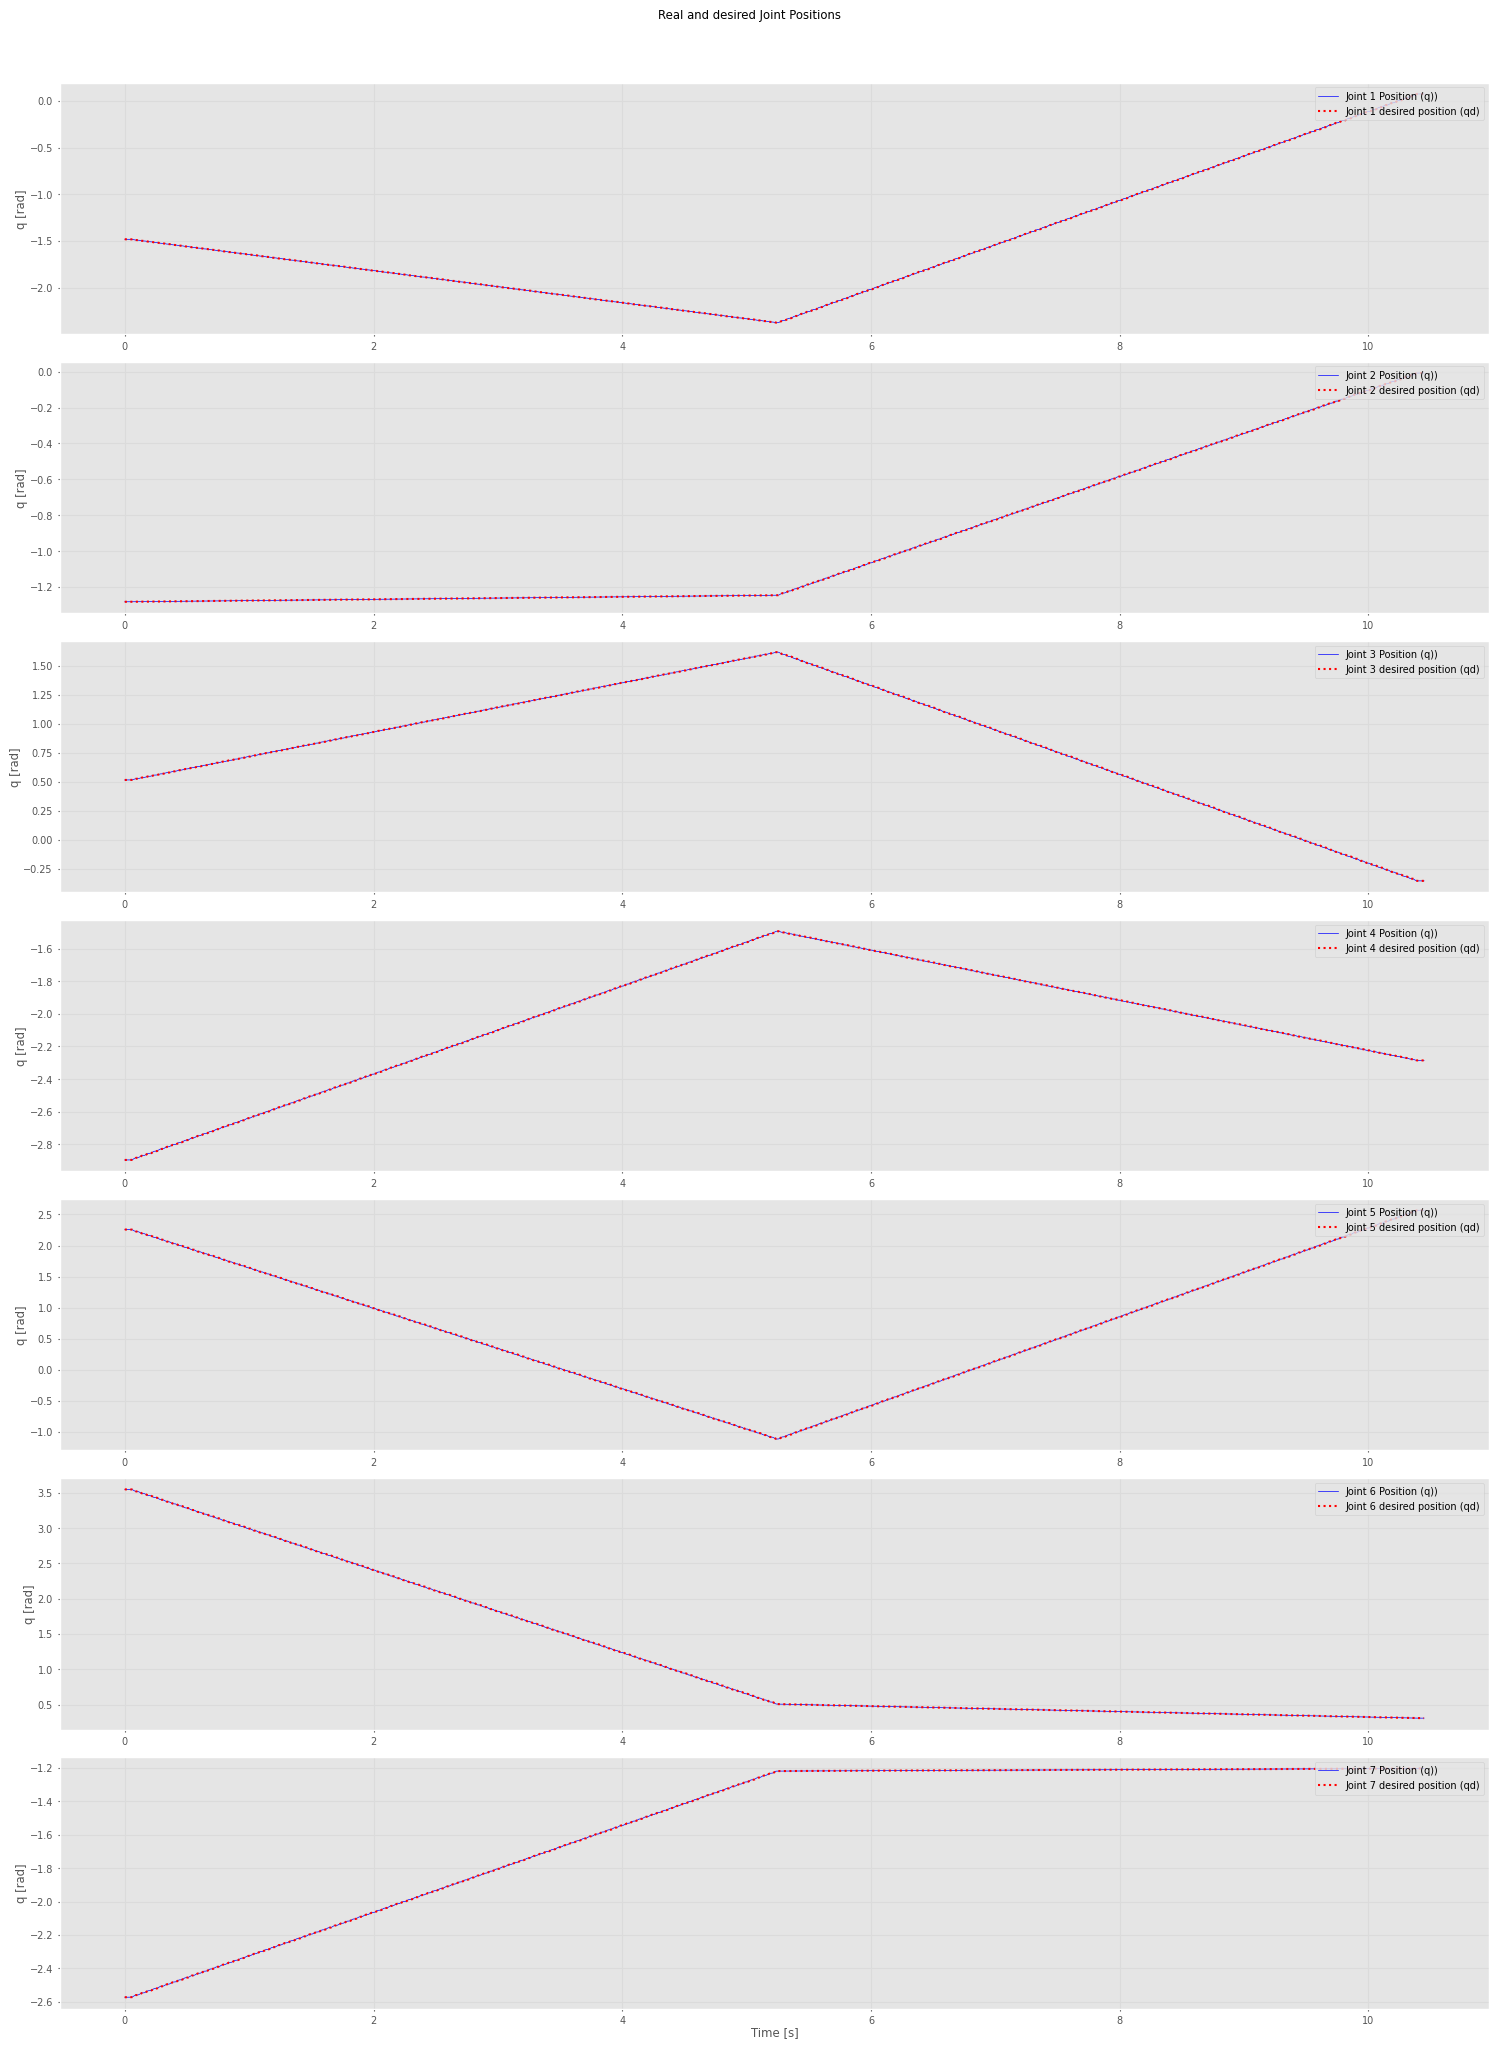

In [17]:
q_all_swapped = q_all_np.swapaxes(0, 1)
qd_swapped = qd_np.swapaxes(0, 1)
num_joints = 7
t = np.arange(q_all_swapped.shape[1])/(N*20)  # Time axis
t2= np.arange(qd_swapped.shape[1])/(N*20)
plt.figure(figsize=(15, 20))  

for i in range(num_joints):
    plt.subplot(num_joints, 1, i+1)  # 7 rows, 1 column
    
    plt.plot(t, q_all_swapped[i], 'b-', label=f'Joint {i+1} Position (q))')
    plt.plot(t2, qd_swapped[i], 'r:', label=f'Joint {i+1} desired position (qd)', linewidth=1.5)
    
    plt.ylabel('q [rad]')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    if i == num_joints - 1:
        plt.xlabel('Time [s]')

plt.suptitle('Real and desired Joint Positions', y=1.02)
plt.tight_layout()
plt.show()


In [18]:
set_joint_positions(robot_id, joint_indices, q_start)

In [19]:
# Run RRT*
path = rrt_star(
    q_start,
    q_goal,
    distance_fn=distance_fn,
    sample_fn=custom_sample_fn,
    extend_fn=extend_fn,
    collision_fn=debug_collision_fn,
    max_iterations=100000,
    max_time=20,
    verbose=True,
    draw_fn=None,  # pass a function to draw sampled points or tree edges
    goal_probability=0.1,  #  how often to sample the goal
    radius=1.0    # radius for rewiring
)


Iteration: 0 | Time: 0.000 | Success: False | True | Cost: inf


In [20]:
if path is None:
    print("No path found!")
else:
    print("Path found with", len(path), "waypoints.")
    for q in path:
        set_joint_positions(robot_id, joint_indices, q)
        time.sleep(0.05)

Path found with 87 waypoints.


In [21]:
t= np.linspace(0,0.02*len(qd), len(qd))
qd_np = np.array(qd)

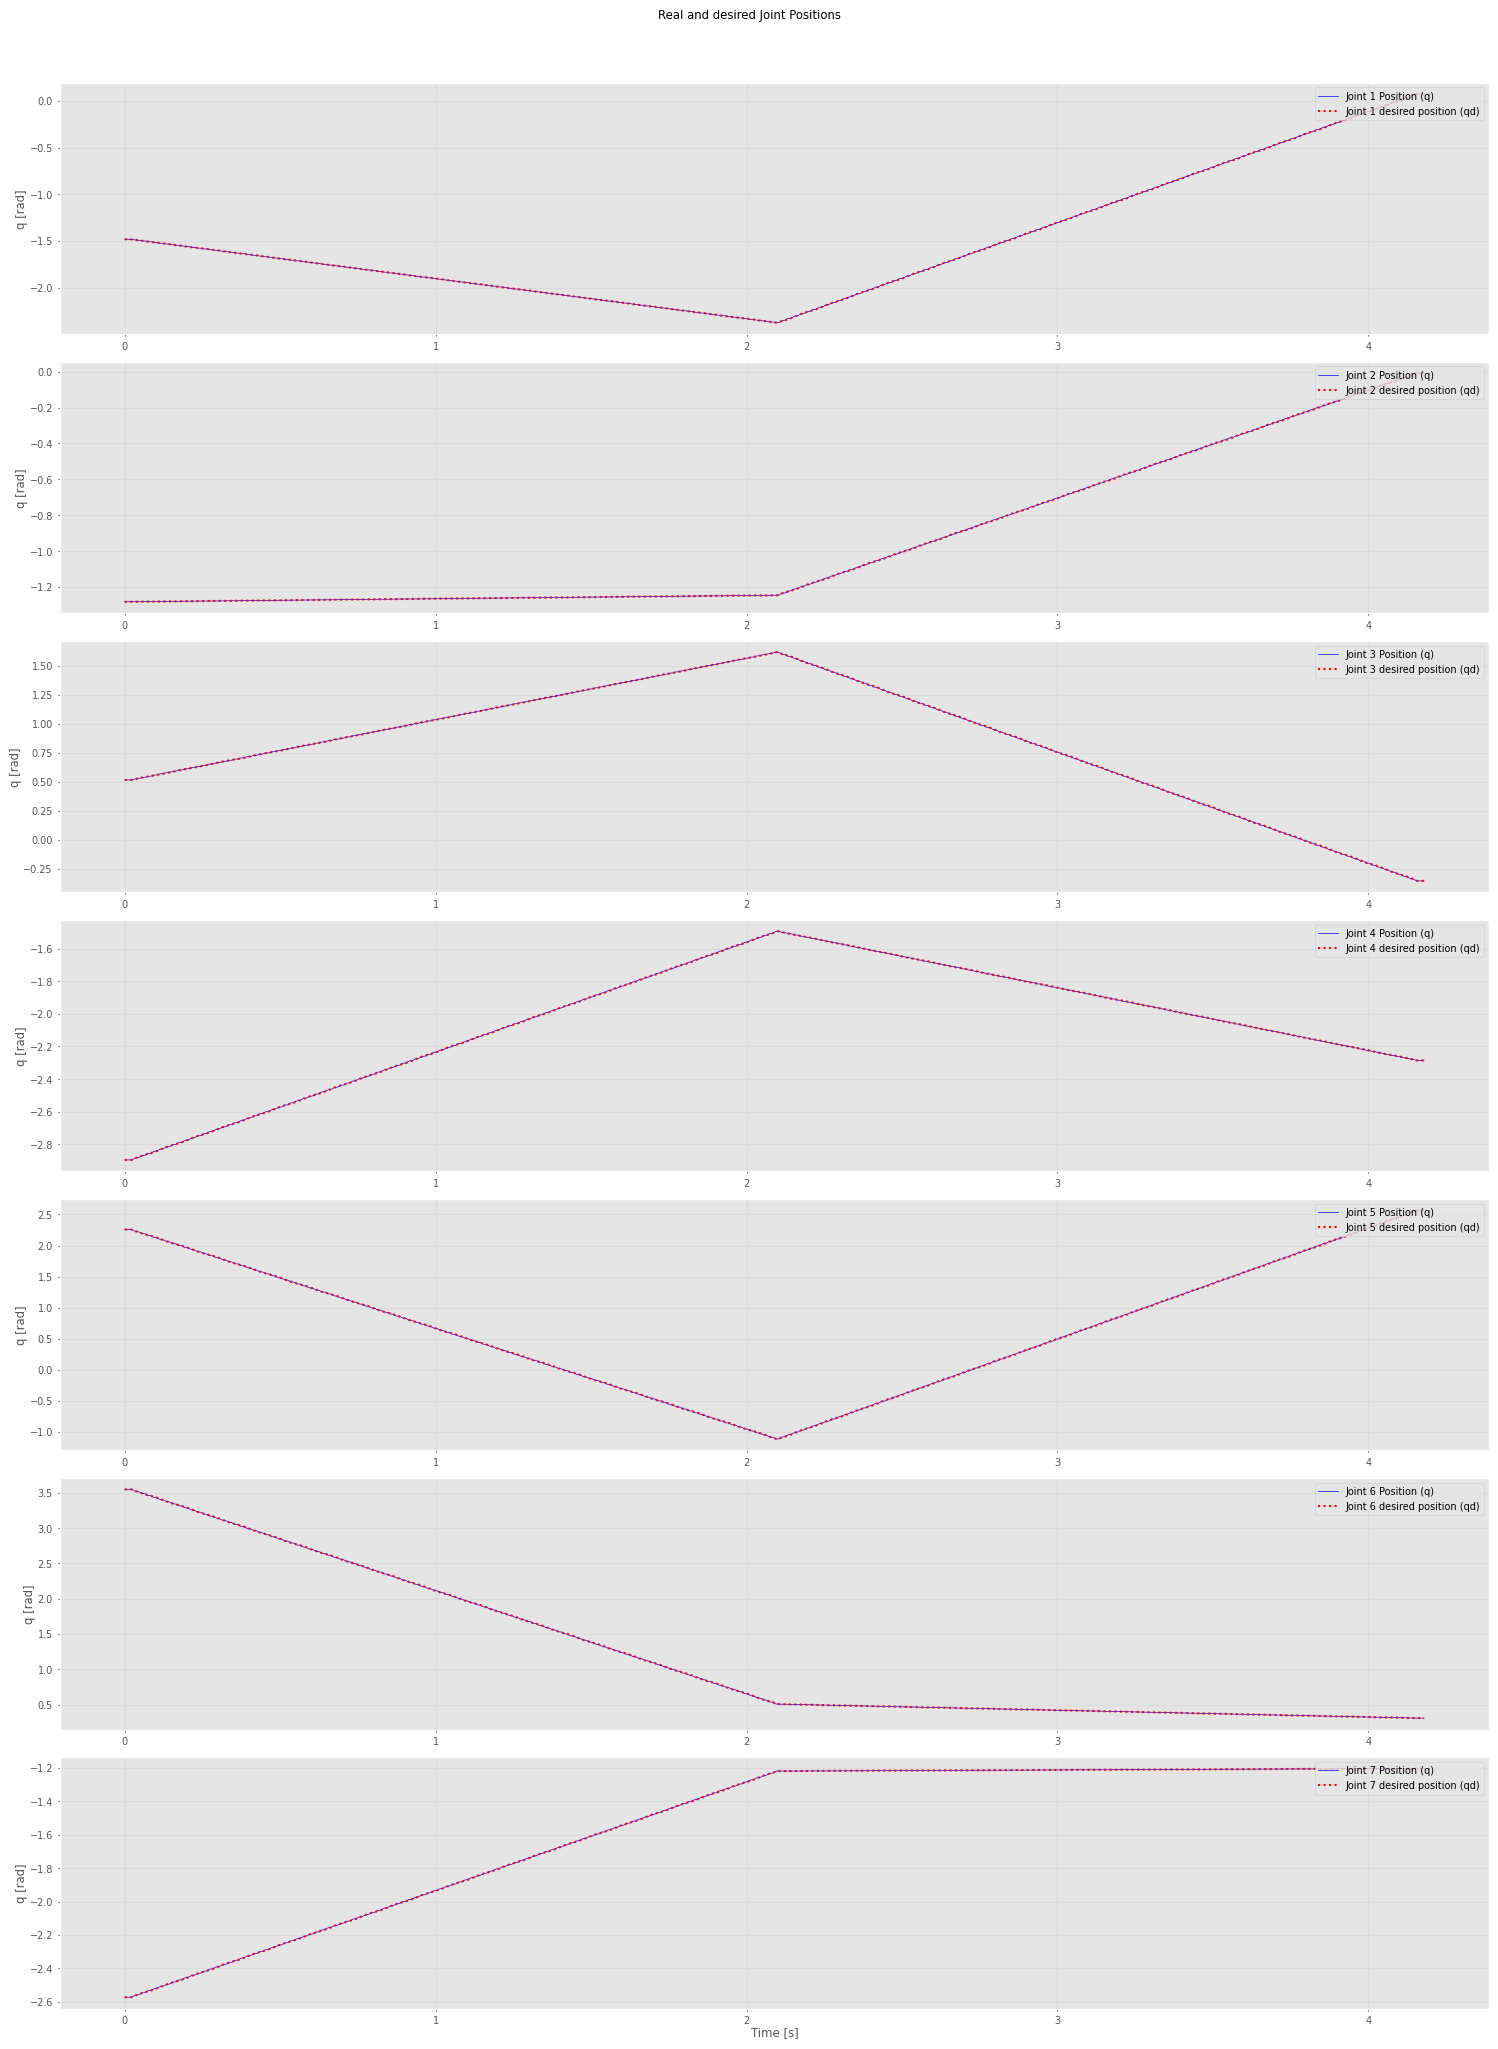

: 

In [ ]:
q_all_swapped = q_all_np.swapaxes(0, 1)
qd_swapped = qd_np.swapaxes(0, 1)
num_joints = 7
t = np.arange(q_all_swapped.shape[1])/(N*50) 
t2= np.arange(qd_swapped.shape[1])/(N*50)
plt.figure(figsize=(15, 20))  

for i in range(num_joints):
    plt.subplot(num_joints, 1, i+1)  
    
    plt.plot(t, q_all_swapped[i], 'b-', label=f'Joint {i+1} Position (q)')
    plt.plot(t2, qd_swapped[i], 'r:', label=f'Joint {i+1} desired position (qd)', linewidth=1.5)
    
    plt.ylabel('q [rad]')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    if i == num_joints - 1:
        plt.xlabel('Time [s]')

plt.suptitle('Real and desired Joint Positions', y=1.02)
plt.tight_layout()
plt.show()
